# Aula 13 - Apredizado Supervisionado (Regressão)




## Desafio!

[Housing Prices at Kaggle!](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)



### Import bibliotecas

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

%matplotlib inline

color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

### Carrega os dados

In [36]:
train = pd.read_csv('data/train.csv')
print('Dados de treino: {}'.format(train.shape))
test = pd.read_csv('data/test.csv')
print('\nDados de teste: {}'.format(test.shape))

Dados de treino: (1460, 81)

Dados de teste: (1459, 80)


### Salva as colunas com ID e dropa dos datasets

In [37]:
trainId = train['Id']
train.drop(['Id'], axis=1, inplace=True)

testId  = test['Id']
test.drop(['Id'], axis=1, inplace=True)

### Visualizando os outliers no conjunto de treino

Text(0.5, 0, 'GrLivArea')

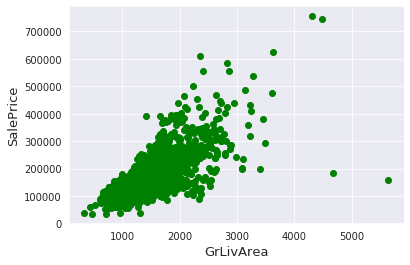

In [38]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'], c='g')
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

### Deletando os outliers identificados no conjunto de treino

Text(0.5, 0, 'GrLivArea')

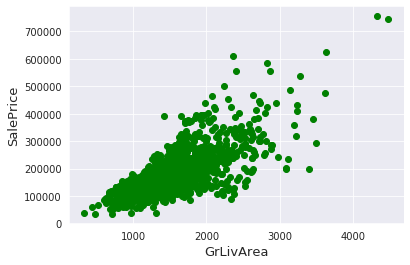

In [39]:
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'], c='g')
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

### Analisando a variável alvo

In [40]:
print('\nPreço mínimo: ${} '.format(train['SalePrice'].min()))
print('\nPreço máximo: ${} '.format(train['SalePrice'].max()))
print('\nPreço médio:  ${} '.format(train['SalePrice'].mean()))


Preço mínimo: $34900 

Preço máximo: $755000 

Preço médio:  $180932.91906721535 


In [41]:
train['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

#### Histograma

Text(0.5, 1.0, 'Distibuição do SalePrice')

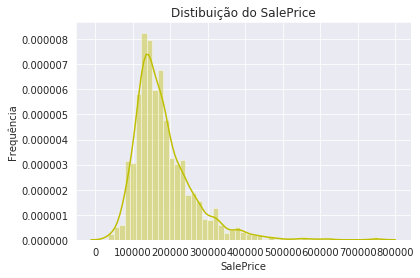

In [42]:
sns.distplot(train['SalePrice'], color='y')
plt.ylabel('Frequência')
plt.title('Distibuição do SalePrice')

#### Gráfico de probabilidade

Text(0.5, 1.0, 'Plot das probabilidades')

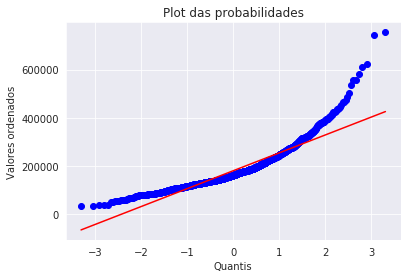

In [43]:
stats.probplot(train['SalePrice'], plot=plt)
plt.xlabel('Quantis')
plt.ylabel('Valores ordenados')
plt.title('Plot das probabilidades')

### Transformação de log da variável de destino

#### A ideia é torná-la mais próxima da distribuição normal

In [44]:
train['SalePrice'] = np.log1p(train['SalePrice']) 

Text(0.5, 1.0, 'Distibuição do SalePrice')

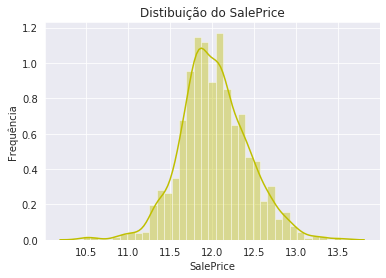

In [45]:
sns.distplot(train['SalePrice'], color='y')
plt.ylabel('Frequência')
plt.title('Distibuição do SalePrice')

Text(0.5, 1.0, 'Plot das probabilidade')

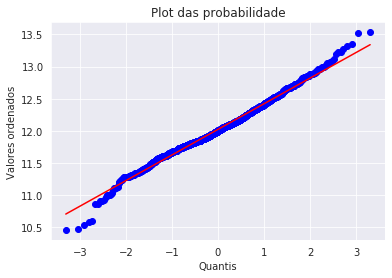

In [46]:
stats.probplot(train['SalePrice'], plot=plt)
plt.xlabel('Quantis')
plt.ylabel('Valores ordenados')
plt.title('Plot das probabilidade')

### Correlação com a target

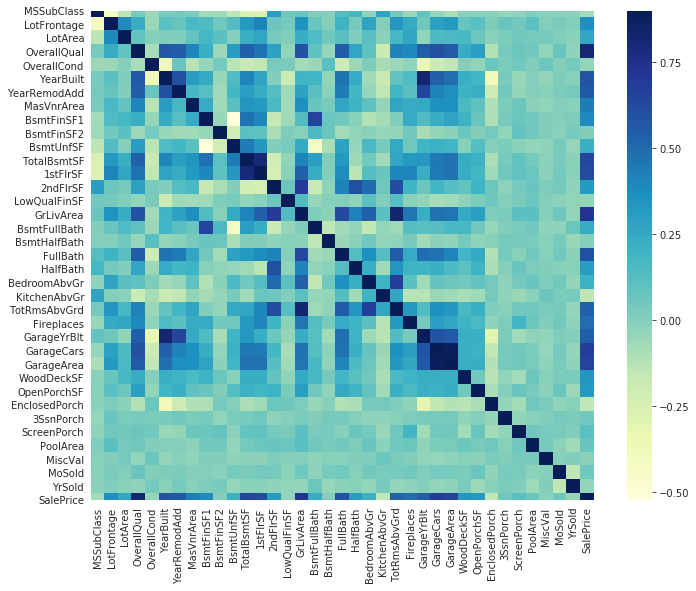

In [53]:
plt.subplots(figsize=(12, 9))
sns.heatmap(train.corr(), vmax=0.9, square=True, cmap='YlGnBu')

## Features engineering

### Salva os shapes para depois redividir os dados

In [54]:
nTrain = train.shape[0]
nTest  = test.shape[0]

### Separa a target

In [55]:
y = train.SalePrice.values
train.drop(['SalePrice'], axis=1, inplace=True)

### Concatena os conjuntos de dados

In [56]:
df = pd.concat((train, test)).reset_index(drop=True)
print('Dataset shape: {} '.format(df.shape))

Dataset shape: (2917, 79) 


### Pré-processamento dos dados

In [57]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [58]:
print('Colunas presentes: ')
df.columns

Colunas presentes: 


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 79 columns):
MSSubClass       2917 non-null int64
MSZoning         2913 non-null object
LotFrontage      2431 non-null float64
LotArea          2917 non-null int64
Street           2917 non-null object
Alley            198 non-null object
LotShape         2917 non-null object
LandContour      2917 non-null object
Utilities        2915 non-null object
LotConfig        2917 non-null object
LandSlope        2917 non-null object
Neighborhood     2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
BldgType         2917 non-null object
HouseStyle       2917 non-null object
OverallQual      2917 non-null int64
OverallCond      2917 non-null int64
YearBuilt        2917 non-null int64
YearRemodAdd     2917 non-null int64
RoofStyle        2917 non-null object
RoofMatl         2917 non-null object
Exterior1st      2916 non-null object
Exterior2nd      2916 non

### Dados faltantes

In [60]:
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
df_na

PoolQC          99.691464
MiscFeature     96.400411
Alley           93.212204
Fence           80.425094
FireplaceQu     48.680151
LotFrontage     16.660953
GarageFinish     5.450806
GarageYrBlt      5.450806
GarageQual       5.450806
GarageCond       5.450806
GarageType       5.382242
BsmtExposure     2.811107
BsmtCond         2.811107
BsmtQual         2.776826
BsmtFinType2     2.742544
BsmtFinType1     2.708262
MasVnrType       0.822763
MasVnrArea       0.788481
MSZoning         0.137127
BsmtFullBath     0.068564
BsmtHalfBath     0.068564
Utilities        0.068564
Functional       0.068564
Exterior2nd      0.034282
Exterior1st      0.034282
SaleType         0.034282
BsmtFinSF1       0.034282
BsmtFinSF2       0.034282
BsmtUnfSF        0.034282
Electrical       0.034282
dtype: float64

Text(0.5, 1.0, 'Valores faltantes por coluna')

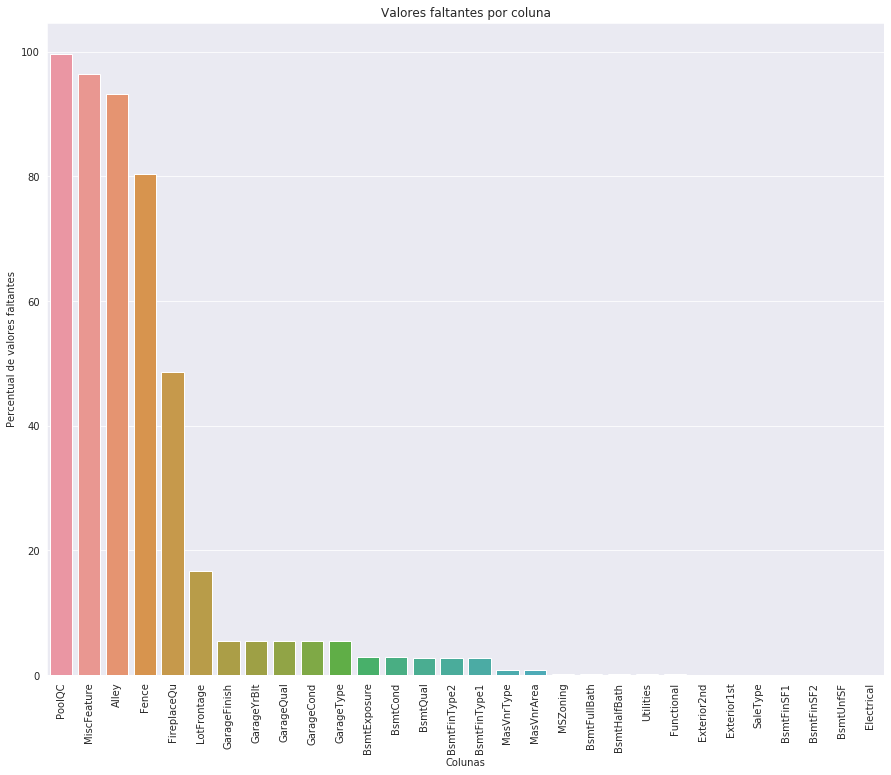

In [61]:
f, ax=plt.subplots(figsize=(15, 12))
sns.barplot(x=df_na.index, y=df_na)

plt.xticks(rotation='90')
plt.xlabel('Colunas')
plt.ylabel('Percentual de valores faltantes')
plt.title('Valores faltantes por coluna')

### Substituindo os dados faltantes

In [76]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

In [83]:
for col in ('PoolQC', 'Alley', 'Fence', 'FireplaceQu', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
            'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'GarageType', 'GarageFinish', 
            'GarageQual', 'GarageCond', 'MSSubClass', 'MiscFeature'):
    df[col] = df[col].fillna('None')

In [78]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
            'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    df[col] = df[col].fillna(0)

In [79]:
for col in ('MSZoning', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Electrical'):
    df[col] = df[col].fillna(df[col].mode()[0])

In [80]:
df['Functional'] = df['Functional'].fillna('Typ')

In [ ]:
df = df.drop(['Utilities'], axis=1)

In [85]:
((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False)

SaleCondition    0.0
BsmtQual         0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
MasVnrArea       0.0
ExterQual        0.0
ExterCond        0.0
Foundation       0.0
BsmtCond         0.0
RoofStyle        0.0
BsmtExposure     0.0
BsmtFinType1     0.0
BsmtFinSF1       0.0
BsmtFinType2     0.0
BsmtFinSF2       0.0
BsmtUnfSF        0.0
TotalBsmtSF      0.0
RoofMatl         0.0
YearRemodAdd     0.0
SaleType         0.0
LotConfig        0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
Street           0.0
Alley            0.0
LotShape         0.0
LandContour      0.0
LandSlope        0.0
                ... 
EnclosedPorch    0.0
ScreenPorch      0.0
Electrical       0.0
PoolArea         0.0
PoolQC           0.0
Fence            0.0
MiscFeature      0.0
MiscVal          0.0
MoSold           0.0
YrSold           0.0
GarageCars       0.0
GarageFinish     0.0
GarageYrBlt      0.0
GarageType       0.0
1stFlrSF         0.0
2ndFlrSF         0.0
LowQualFinSF 

### Transformação dos dados

In [86]:
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['OverallCond'] = df['OverallCond'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [88]:
for cols in ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 
        'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 
        'GarageFinish', 'LandSlope','LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 
        'OverallCond', 'YrSold', 'MoSold'):
    
    encoder = LabelEncoder()
    encoder.fit(list(df[cols].values))
    df[cols] = encoder.transform(list(df[cols].values))

df.shape

(2917, 78)

### Adicionando um novo recurso: área total do porão

In [89]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

### Inclinação dos recursos

In [91]:
numeric_feats = df.dtypes[df.dtypes != 'O'].index

skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

print('\nInclinação das colunas numéricas:')
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Inclinação das colunas numéricas:


,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


### Box Cox Transformation

#### Trnasformação box cox é uma maneira de transformar variáveis dependentes não normais em uma forma normal.

In [93]:
skewness = skewness[abs(skewness) > 0.75]
print('Existem {} recursos numéricos inclinados para Box Cox transformation'.format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15

for feat in skewed_features:
    df[feat] = boxcox1p(df[feat], lam)

Existem 59 recursos numéricos inclinados para Box Cox transformation


### Aplicando dummy nas colunas categóricas

In [94]:
df = pd.get_dummies(df)
print(df.shape)

(2917, 220)


### Redividindo os dados

In [95]:
train = df[:nTrain]
test =  df[nTrain:]

### Modelagem

### Importando as bibliotecas

In [98]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

### Cross validation

In [107]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y, scoring='neg_mean_squared_error', cv = kf))
    return(rmse)

### Modelos

In [108]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [109]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [110]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [111]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [112]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [113]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Desempenho dos modelos

In [114]:
score = rmsle_cv(lasso)
print('\nLasso score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))


Lasso score: 0.1141 (0.0083)



In [115]:
score = rmsle_cv(ENet)
print('ElasticNet score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

ElasticNet score: 0.1141 (0.0083)



In [116]:
score = rmsle_cv(KRR)
print('Kernel Ridge score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

Kernel Ridge score: 0.1334 (0.0071)



In [117]:
score = rmsle_cv(GBoost)
print('Gradient Boosting score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)



In [118]:
score = rmsle_cv(model_xgb)
print('Xgboost score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

Xgboost score: 0.1150 (0.0068)



In [119]:
score = rmsle_cv(model_lgb)
print('LGBM score: {:.4f} ({:.4f})\n' .format(score.mean(), score.std()))

LGBM score: 0.1161 (0.0058)



### Empilhamento das médias dos modelos

In [120]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        

        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [121]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print('Média dos modelos: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

Média dos modelos: 0.1119 (0.0082)



### Empilhamento menos simples

In [122]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [123]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print('Stacking Averaged models score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Stacking Averaged models score: 0.1087 (0.0076)


### Ensembling

In [124]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Predição final

#### StackedRegressor:

In [127]:
stacked_averaged_models.fit(train.values, y)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y, stacked_train_pred))

0.07692433539873111


#### XGBoost:

In [128]:
model_xgb.fit(train, y)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y, xgb_train_pred))

0.07900731928290237


#### LightGBM:

In [129]:
model_lgb.fit(train, y)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y, lgb_train_pred))

0.07268708888422705


In [130]:
print('RMSLE score on train data:')
print(rmsle(y,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07440282607259822


#### Ensemble prediction:

In [131]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

### Salvando os dados para submissão

In [132]:
sample = testId.to_frame()
sample['SalePrice'] = ensemble
sample.to_csv('data/sample_submission.csv', index=False)
sample

,Id,SalePrice
0,1461,120265.885438
1,1462,156649.386855
2,1463,188174.697126
3,1464,196104.230947
4,1465,191728.184617
5,1466,173552.933870
6,1467,174289.188618
7,1468,163925.549646
8,1469,183987.801766
9,1470,122868.204239
